<a href="https://colab.research.google.com/github/FriendlyUser/finance-notebooks/blob/master/Stock_algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

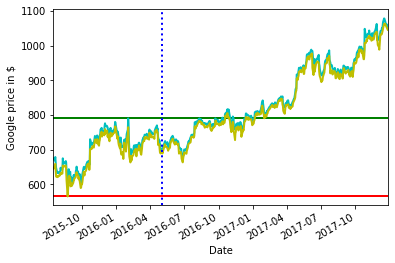

In [2]:
import pandas as pd
from pandas_datareader import data
start_date = '2014-01-01'
end_date = '2018-01-01'
SRC_DATA_FILENAME='goog_data.pkl'
try:
  goog_data2 = pd.read_pickle(SRC_DATA_FILENAME)
except FileNotFoundError:
  goog_data2 = data.DataReader('GOOG', 'yahoo', start_date, end_date)
  goog_data2.to_pickle(SRC_DATA_FILENAME)
  goog_data=goog_data2.tail(620)
  lows=goog_data['Low']
  highs=goog_data['High']
import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='Google price in $')
highs.plot(ax=ax1, color='c', lw=2.)
lows.plot(ax=ax1, color='y', lw=2.)
plt.hlines(highs.head(200).max(),lows.index.values[0],lows.index.values[-1]
,linewidth=2, color='g')
plt.hlines(lows.head(200).min(),lows.index.values[0],lows.index.values[-1],
linewidth=2, color='r')
plt.axvline(linewidth=2,color='b',x=lows.index.values[200],linestyle=':')
plt.show()

In this plot, the following applies:

1.  We draw the highs and lows of the GOOG price.
2.   The green line represents the resistance level, and the red line represents the support level.
3. To build these lines, we use the maximum value of the GOOG price and the
minimum value of the GOOG price stored daily.
4, After the 200th day (dotted vertical blue line), we will buy when we reach the support line, and sell when we reach the resistance line. In this example, we used 200 days so that we have sufficient data points to get an estimate of the trend.
5. It is observed that the GOOG price will reach the resistance line around August 2016. This means that we have a signal to enter a short position (sell).
6. Once traded, we will wait to get out of this short position when the GOOG price will reach the support line. With this historical data, it is easily noticeable that this condition will not happen.
7. This will result in carrying a short position in a rising market without having any signal to sell it, thereby resulting in a huge loss.

File data found...reading GOOG data


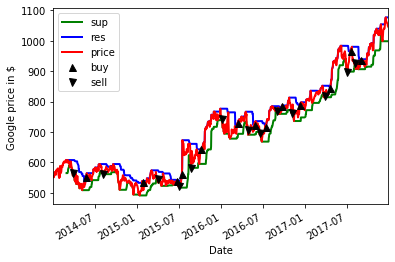

In [4]:
import pandas as pd
import numpy as np
from pandas_datareader import data
start_date = '2014-01-01'
end_date = '2018-01-01'
SRC_DATA_FILENAME='goog_data.pkl'
try:
  goog_data = pd.read_pickle(SRC_DATA_FILENAME)
  print('File data found...reading GOOG data')
except FileNotFoundError:
  print('File not found...downloading the GOOG data')
  goog_data = data.DataReader('GOOG', 'yahoo', start_date, end_date)
  goog_data.to_pickle(SRC_DATA_FILENAME)

goog_data_signal = pd.DataFrame(index=goog_data.index)
goog_data_signal['price'] = goog_data['Adj Close']

def trading_support_resistance(data, bin_width=20):
  data['sup_tolerance'] = pd.Series(np.zeros(len(data)))
  data['res_tolerance'] = pd.Series(np.zeros(len(data)))
  data['sup_count'] = pd.Series(np.zeros(len(data)))
  data['res_count'] = pd.Series(np.zeros(len(data)))
  data['sup'] = pd.Series(np.zeros(len(data)))
  data['res'] = pd.Series(np.zeros(len(data)))
  data['positions'] = pd.Series(np.zeros(len(data)))
  data['signal'] = pd.Series(np.zeros(len(data)))
  in_support=0
  in_resistance=0
  for x in range((bin_width - 1) + bin_width, len(data)):
    data_section = data[x - bin_width:x + 1]
    support_level=min(data_section['price'])
    resistance_level=max(data_section['price'])
    range_level=resistance_level-support_level
    data['res'][x]=resistance_level
    data['sup'][x]=support_level
    data['sup_tolerance'][x]=support_level + 0.2 * range_level
    data['res_tolerance'][x]=resistance_level - 0.2 * range_level
    if data['price'][x]>=data['res_tolerance'][x] and\
      data['price'][x] <= data['res'][x]:
      in_resistance+=1
      data['res_count'][x]=in_resistance
    elif data['price'][x] <= data['sup_tolerance'][x] and \
      data['price'][x] >= data['sup'][x]:
      in_support += 1
      data['sup_count'][x] = in_support
    else:
      in_support=0
      in_resistance=0
    if in_resistance>2:
      data['signal'][x]=1
    elif in_support>2:
      data['signal'][x]=0
    else:
      data['signal'][x] = data['signal'][x-1]
  data['positions']=data['signal'].diff()
trading_support_resistance(goog_data_signal)

import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='Google price in $')
goog_data_signal['sup'].plot(ax=ax1, color='g', lw=2.)
goog_data_signal['res'].plot(ax=ax1, color='b', lw=2.)
goog_data_signal['price'].plot(ax=ax1, color='r', lw=2.)
ax1.plot(goog_data_signal.loc[goog_data_signal.positions == 1.0].index,
goog_data_signal.price[goog_data_signal.positions == 1.0],
'^', markersize=7, color='k',label='buy')
ax1.plot(goog_data_signal.loc[goog_data_signal.positions == -1.0].index,
goog_data_signal.price[goog_data_signal.positions == -1.0],
'v', markersize=7, color='k',label='sell')
plt.legend()
plt.show()

Simple Moving Average:
It is basically the price average over a certain time period, with
equal weight being used for each price. The time period over which it is averaged is often referred to as the lookback period or history.
SMA = $\frac{\sum_{i=1}^{N}Pi}{N}$

$P_i$: Price at time period i.

$N$: Number of prices added together or the number of time periods

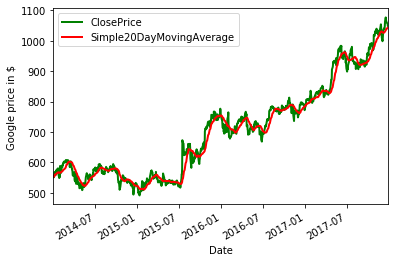

In [8]:
import statistics as stats
time_period = 20 # number of days over which to average
history = [] # to track a history of prices
sma_values = [] # to track simple moving average values
close = goog_data['Adj Close']
for close_price in close:
  history.append(close_price)
  if len(history) > time_period: # we remove oldest price because we only average over last 'time_period' prices
    del (history[0])
  sma_values.append(stats.mean(history))

goog_data = goog_data.assign(ClosePrice=pd.Series(close, index=goog_data.index))
goog_data = goog_data.assign(Simple20DayMovingAverage=pd.Series(sma_values,
index=goog_data.index))
close_price = goog_data['ClosePrice']
sma = goog_data['Simple20DayMovingAverage']
import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='Google price in $')
close_price.plot(ax=ax1, color='g', lw=2., legend=True)
sma.plot(ax=ax1, color='r', lw=2., legend=True)
plt.show()

EMA: The EMA is similar to the simple moving average, but, instead of weighing all prices in the
history equally, it places more weight on the most recent price observation and less weight
on the older price observations.

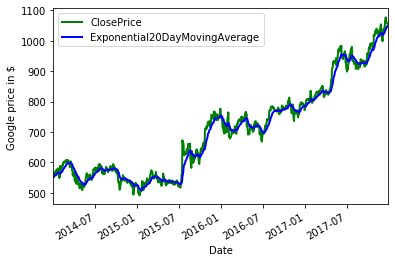

In [10]:
num_periods = 20 # number of days over which to average
K = 2 / (num_periods + 1) # smoothing constant
ema_p = 0
ema_values = [] # to hold computed EMA values
for close_price in close:
  if (ema_p == 0): # first observation, EMA = current-price
    ema_p = close_price
  else:
    ema_p = (close_price - ema_p) * K + ema_p
  ema_values.append(ema_p)

goog_data = goog_data.assign(ClosePrice=pd.Series(close,
index=goog_data.index))
goog_data = goog_data.assign(Exponential20DayMovingAverage=pd.Series(ema_values,
index=goog_data.index))
close_price = goog_data['ClosePrice']
ema = goog_data['Exponential20DayMovingAverage']
import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='Google price in $')
close_price.plot(ax=ax1, color='g', lw=2., legend=True)
ema.plot(ax=ax1, color='b', lw=2., legend=True)
plt.savefig('ema.png')
plt.show()

Implementation of the absolute price oscillator

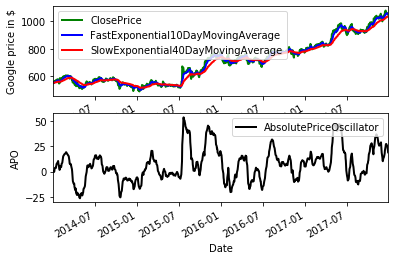

In [13]:
num_periods_fast = 10 # time period for the fast EMA
K_fast = 2 / (num_periods_fast + 1) # smoothing factor for fast EMA
ema_fast = 0
num_periods_slow = 40 # time period for slow EMA
K_slow = 2 / (num_periods_slow + 1) # smoothing factor for slow EMA
ema_slow = 0
ema_fast_values = [] # we will hold fast EMA values for visualizationpurposes
ema_slow_values = [] # we will hold slow EMA values for visualization purposes
apo_values = [] # track computed absolute price oscillator values
for close_price in close:
  if (ema_fast == 0): # first observation
    ema_fast = close_price
    ema_slow = close_price
  else:
    ema_fast = (close_price - ema_fast) * K_fast + ema_fast
    ema_slow = (close_price - ema_slow) * K_slow + ema_slow
  ema_fast_values.append(ema_fast)
  ema_slow_values.append(ema_slow)
  apo_values.append(ema_fast - ema_slow)

goog_data = goog_data.assign(ClosePrice=pd.Series(close,index=goog_data.index))
goog_data = goog_data.assign(FastExponential10DayMovingAverage=pd.Series(ema_fast_values, index=goog_data.index))
goog_data = goog_data.assign(SlowExponential40DayMovingAverage=pd.Series(ema_slow_values, index=goog_data.index))
goog_data = goog_data.assign(AbsolutePriceOscillator=pd.Series(apo_values,
index=goog_data.index))
close_price = goog_data['ClosePrice']
ema_f = goog_data['FastExponential10DayMovingAverage']
ema_s = goog_data['SlowExponential40DayMovingAverage']
apo = goog_data['AbsolutePriceOscillator']
import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = fig.add_subplot(211, ylabel='Google price in $')
close_price.plot(ax=ax1, color='g', lw=2., legend=True)
ema_f.plot(ax=ax1, color='b', lw=2., legend=True)
ema_s.plot(ax=ax1, color='r', lw=2., legend=True)
ax2 = fig.add_subplot(212, ylabel='APO')
apo.plot(ax=ax2, color='black', lw=2., legend=True)
plt.show()

One observation here is the difference in behavior between fast and slow EMAs. The faster
one is more reactive to new price observations, and the slower one is less reactive to new
price observations and decays slower. The APO values are positive when prices are
breaking out to the upside, and the magnitude of the APO values captures the magnitude
of the breakout. The APO values are negative when prices are breaking out to the
downside, and the magnitude of the APO values captures the magnitude of the breakout.